Просто ради интереса, попробуем различные методы кластеризации на тех данных, что использовали для нейронной сети, которая решает задачу классификации

In [1]:
# ну конечно подключим pandas
import pandas as pd

# display() для удобства
from IPython.display import display

# есть категориальные данные - нужно будет кодировать
from sklearn.preprocessing import OrdinalEncoder

from sklearn.cluster import KMeans

# что забыли? Правильно, метод для разделения выборки на тренировочную и валидационную
from sklearn.model_selection import train_test_split

# ну и на всякий случай для перемешивания при up/down-сэмплинге
from sklearn.utils import shuffle


import matplotlib.pyplot as plt
import random

In [2]:
df = pd.read_csv('../drug classification/drug200.csv')

In [30]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


Уже точно известно (см. откуда данные), что с данными все нормально (за исключением того, что присутствует явный дисбаланс классов), поэтому проверять их снова не будем.
Поскольку у нас есть текстовые данные и данные уже классифицированы, то нам нужно убрать столбец классификации и закодировать текстовые данные методом OHE.

In [4]:
columns_for_encoding = []
for i in range(0,df.shape[1]):
    if (df[df.columns[i]].dtype == 'object'):
        columns_for_encoding.append(df.columns[i])
        
encoder = OrdinalEncoder()

df_OHE = df.copy()

df_OHE[columns_for_encoding] = pd.DataFrame(encoder.fit_transform(df[columns_for_encoding]), columns=columns_for_encoding)




features = df_OHE.drop('Drug', axis=1)
target = df_OHE['Drug']

display(features.head())
display(target.tail())

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,0.0,0.0,0.0,25.355
1,47,1.0,1.0,0.0,13.093
2,47,1.0,1.0,0.0,10.114
3,28,0.0,2.0,0.0,7.798
4,61,0.0,1.0,0.0,18.043


195    3.0
196    3.0
197    4.0
198    4.0
199    4.0
Name: Drug, dtype: float64

Отлично. Данные готовы. Попробуем разные методы кластеризации.

### Метод K-Means

Попробуем метод к-средних, как одну из вариаций метода KNN (K ближайших соседей)
Разобъем данные на тестовые и валидационные и попробуем.

In [5]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, random_state=12345)

model = KMeans(n_clusters=5)

model.fit(features_train)

predicted_label = model.predict(features_valid)



Ну и посмотрим на результаты. Поскольку будем перебирать разные варианты кластеризации, то напишем сразу функцию.

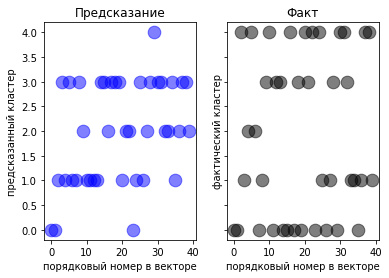

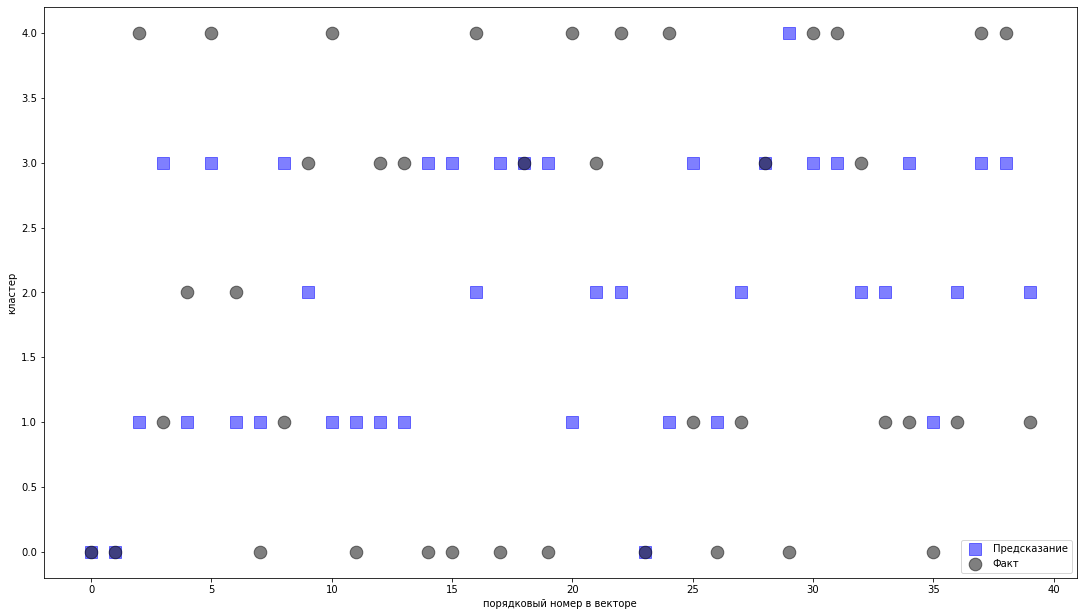

In [6]:

def plotting(x1,x2,y1,y2):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    color1 = 'blue'
    area = 160  
    ax1.scatter(x1, y1, s=area, c=color1, alpha=0.5)
    ax1.set_title('Предсказание')
    ax1.set_xlabel('порядковый номер в векторе')
    ax1.set_ylabel('предсказанный кластер')

    color2 = 'black'
    ax2.scatter(x2, y2, s=area, c=color2, alpha=0.5)
    ax2.set_title('Факт')
    ax2.set_xlabel('порядковый номер в векторе')
    ax2.set_ylabel('фактический кластер')


    plt.show()


    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax3 = fig.add_subplot(111)
    ax3.scatter(x1, y1, s=area, c=color1, marker="s", label='Предсказание', alpha=0.5)
    ax3.scatter(x2,y2, s=area, c=color2, marker="o", label='Факт', alpha=0.5)
    ax1.set_title('Предсказание')
    ax3.set_xlabel('порядковый номер в векторе')
    ax3.set_ylabel('кластер')
    plt.legend(loc='best');
    plt.show()



plotting(
        x1 = range(0, len(predicted_label),1),
        y1 = predicted_label,
        x2 = range(0, len(target_valid),1),
        y2 = target_valid
    )

Не то чтобы очень хорошо справился. Зато быстро.

Вообще, это конечно круто, проверять как разбивает, если мы знаем кластеры. 

### А что если...
мы не знаем количество кластеров? Что если нужно определить количество кластеров и разбить по ним? Можно и такое. Но встает вопрос "как определить количество кластеров, на которые разбивать". На этот вопрос есть ответ - "Elbow method". Попробуем представить, что у нас нет тренировочной и валидационной выборок, а есть только 1 и нам нужно разбить ее на кластеры. 

Для начала определим количество кластеров, на которые нужно разбивать данные.

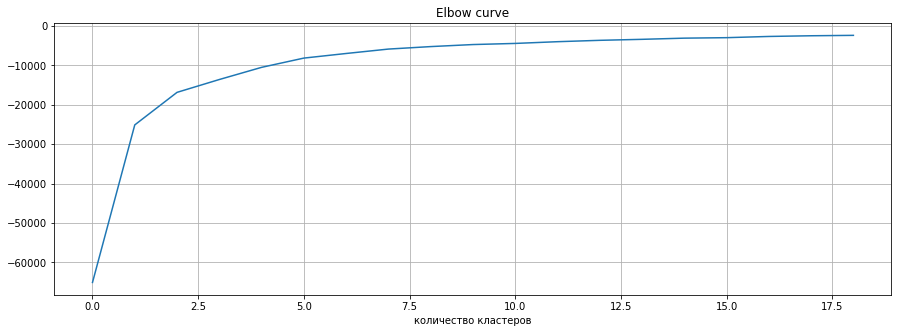

In [21]:
scores = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features)
    scores.append(km.score(features))


fig = plt.figure(figsize=(15, 5))
plt.plot(range(0, len(scores),1), scores)
plt.grid(True)
plt.xlabel('количество кластеров')
plt.title('Elbow curve')
plt.show()

Отлично, видно, что локоть у нас в районе от 2 до 5 кластеров, что соответстует действительности (в исходных данных 5 кластеров). Посмотрим на промежутке от 1 до 6 кластеров.

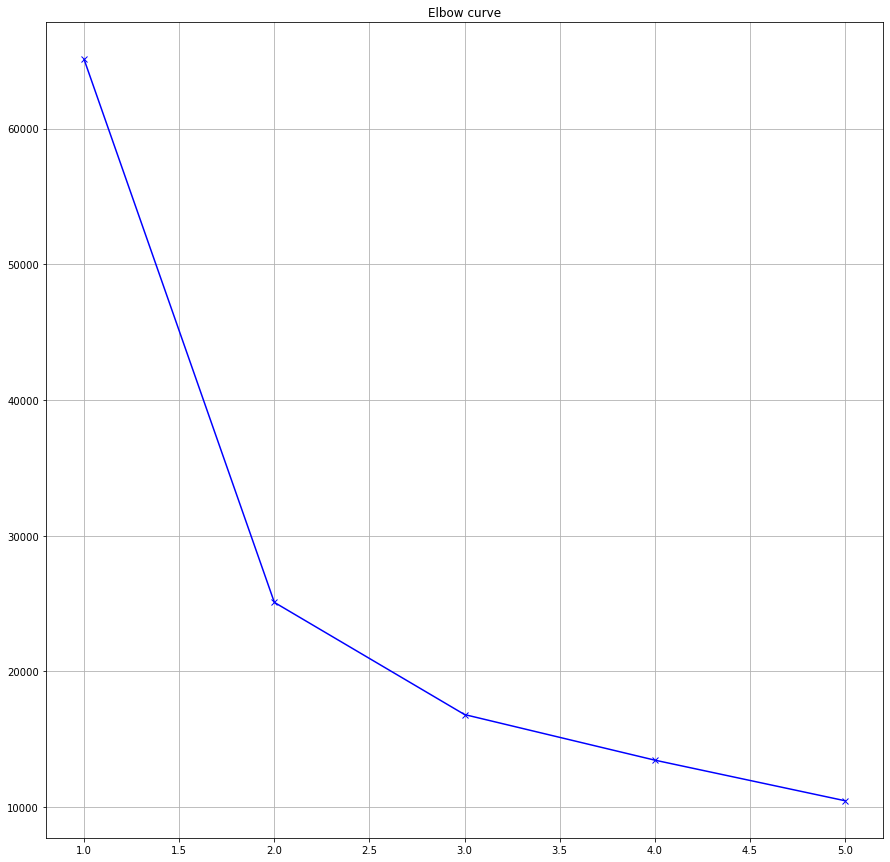

In [34]:
scores = []
K = range(1,6)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features)
    scores.append(km.inertia_)


fig = plt.figure(figsize=(15, 15))
plt.plot(range(1, len(scores)+1,1), scores, 'bx-')
plt.grid(True)
plt.title('Elbow curve')
plt.show()

Нууууу... стандартным евклидовым растоянием мы получаем локоть в районе 3 кластеров и должны разбить данные на 3 кластера.
Тогда наша кластеризация выглядела бы так

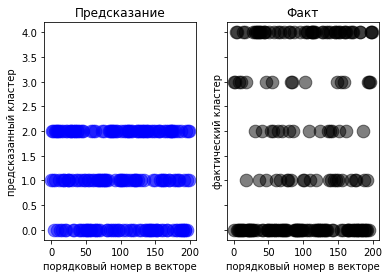

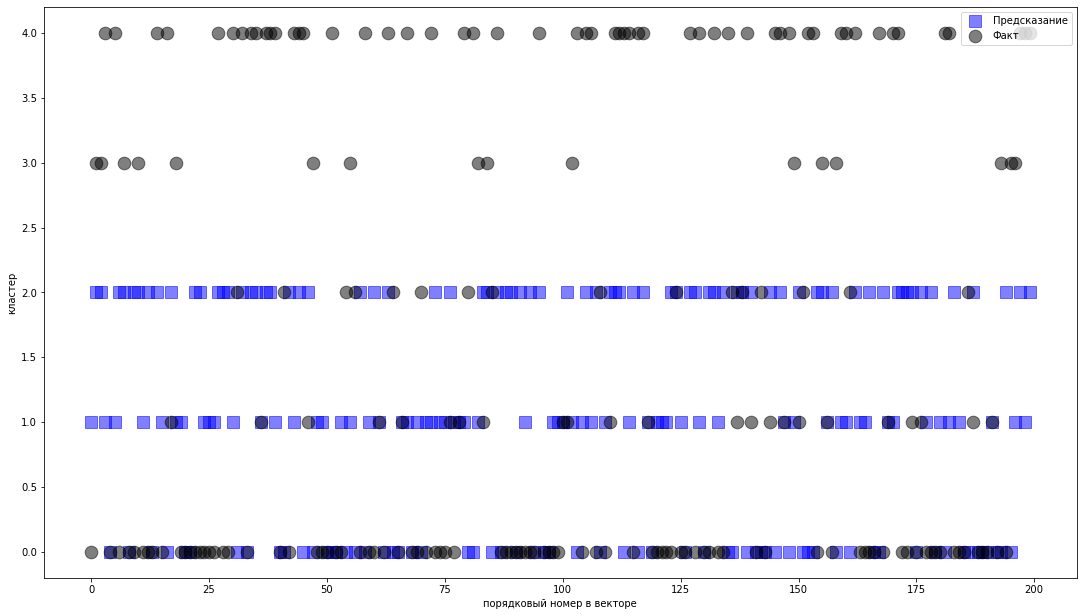

In [36]:
model=KMeans(n_clusters=3)
predicted_label = model.fit(features).predict(features)

plotting(
        x1 = range(0, len(predicted_label),1),
        y1 = predicted_label,
        x2 = range(0, len(target),1),
        y2 = target
    )

### Иерархическая кластеризация

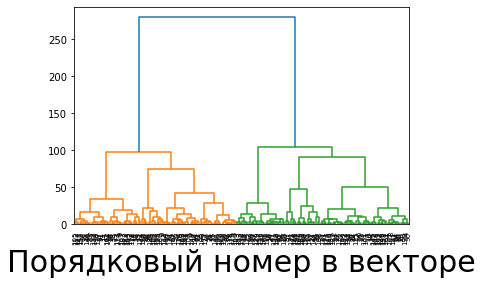

<Figure size 1440x2160 with 0 Axes>

In [71]:
from scipy.cluster.hierarchy import linkage, dendrogram


varieties = range(0, len(predicted_label),1)

# Извлекаем измерения как массив NumPy
samples = features.values

# Реализация иерархической кластеризации при помощи функции linkage
# method=’single’  - KNN
# method=’complete’ - Алгоритм Voor Hees
# method='ward' - Метод минимальной дисперсии Уорда
# method='centroid' - Unweighted Pair Group Method with Centroid average
# method='average' - Агломерационной иерархическая кластеризация UPGMA
# method='weighted'- Агломерационная иерархическая кластеризация Сокала и Михенеру
# method='median' - WPGMC 

mergings = linkage(samples, method='ward' )

# Строим дендрограмму, указав параметры удобные для отображения
dendrogram(mergings,
           labels=varieties,
           leaf_rotation=90,
           leaf_font_size=7
           )

plt.xlabel('Порядковый номер в векторе', fontsize=30)

plt.figure(figsize=(20,30))
plt.show()

Посмотрим, насколько точно кластеризует.

In [94]:
# вытащим кластера
from scipy.cluster.hierarchy import fcluster
f = fcluster(mergings,5,criterion='maxclust')

# сложим их в датафрейм
temp = pd.DataFrame({'drug': target, 'cluster':f}).pivot_table(index='drug', values='cluster', aggfunc='count')

# посчитаем размер реальных кластеров из входных данных
count_target_unique = {}
for el in target.unique():
    count_target_unique[el] = target[target == el].count()

# посмотрим как наша кластеризация соотностится со входными данными
temp['real_number_of_items_in_the_cluster'] = pd.Series(count_target_unique)
display(temp)

,cluster,real_number_of_items_in_the_cluster
drug,,
0.0,91,91
1.0,23,23
2.0,16,16
3.0,16,16
4.0,54,54


Нуууу... по крайней мере размерность кластеров соблюдена. Про состав класеров - отдельный вопрос, как и про то, сколько кластеров мы хотим увидеть.

### GMM

Попробуем кластеризовать гауссовской моделью, которая пытается найти такую смесь многомерных гауссовых распределений вероятностей, которая наилучшим образом моделирует входной набор данных. 
На первом этапе, как и в случае с К-средних, перед нами встает вопрос выбора количества кластеров. Тут нам на помощь приходят 2 критерия которые показывают компромисс между точностью и сложностью модели: баессовский информационный (bic) и информационный критерий Акаике. Оба критерия, чем меньше - тем лучше. 

Пришло время проверить

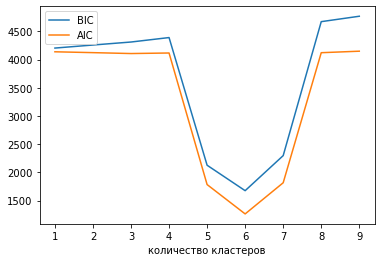

In [64]:
from sklearn.mixture import GaussianMixture as GMM

n_components = range(1,10)
models = [GMM(n, covariance_type='full', random_state=0).fit(features) for n in n_components]

plt.plot(n_components, [m.bic(features) for m in models], label='BIC')
plt.plot(n_components, [m.aic(features) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('количество кластеров');

Ну чтож... 6 так шесть.

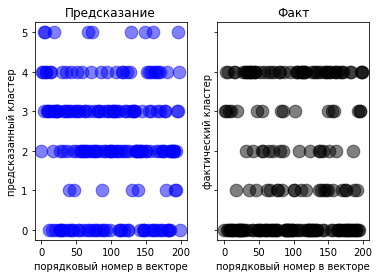

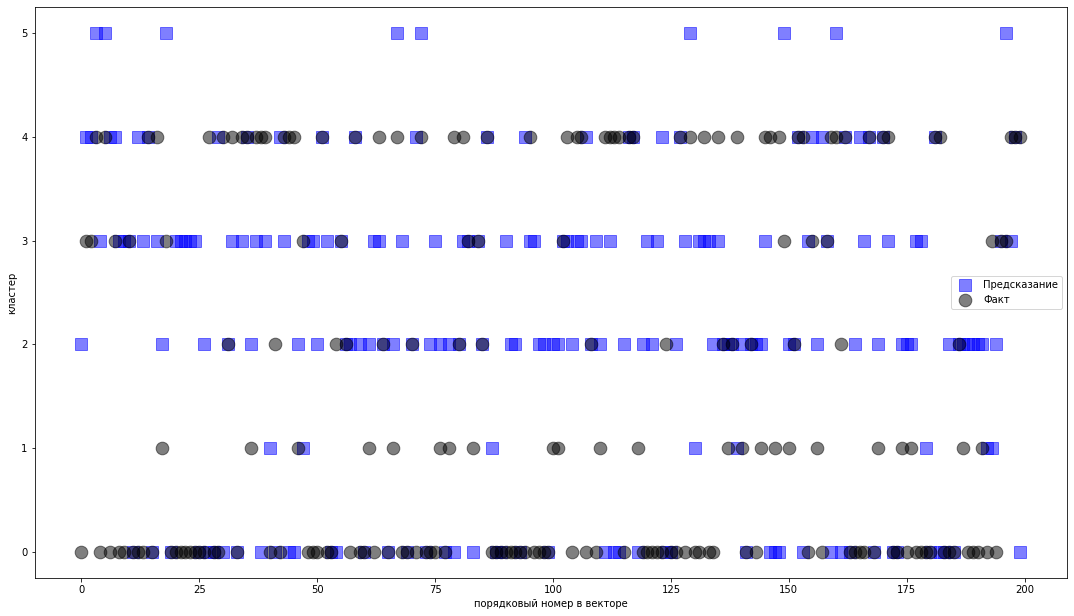

In [66]:
model = GMM(6, covariance_type='full', random_state=0)
model.fit(features)
predicted_label = model.predict(features)

plotting(
        x1 = range(0, len(predicted_label),1),
        y1 = predicted_label,
        x2 = range(0, len(target),1),
        y2 = target
    )

### Вывод
задача кластеризации - не тривиальная задача и в ней существует множество подходов и множество критериев, необходимо тщательно подбирать алгоритмы кластеризации и алгоритмы расчета расстояния между точками. Но даже при условии тщательно подготовки нет 100% гарантии, что все будет кластеризованно правильно, мы можем только с определенной долей уверенности сказать, что истенное количество кластеров находится в определенном диапазоне.